In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
ab=pd.read_pickle('../../Data/AB.pkl')
aab=pd.read_pickle('../../Data/AAB.pkl')
abb=pd.read_pickle('../../Data/ABB.pkl')

In [3]:
vdjdb=pd.DataFrame(np.genfromtxt('../../Data/VDJdb.txt',delimiter='\t',dtype='unicode',autostrip=True))
vdjdb.columns=vdjdb.iloc[0]
vdjdb=vdjdb.iloc[1:]

In [4]:
def truncate_germline_names(data):    
    """
    Prepare gerlmine names s.t. the format matches the V/J region names provided names
    """
    if 'A' in data:
        which='A'
    else:
        which='B'
    if '*' in data:
        value=data[data.find(which)+2:data.find('*')]
    else:
        value=data[data.find(which)+2:]
    return value

In [5]:
vdjdb.V=list(map(truncate_germline_names,vdjdb.V))
vdjdb.J=list(map(truncate_germline_names,vdjdb.J))
chain=[]
for x in vdjdb.Gene:
    if x=='TRA':
        chain.append('Alpha')
    elif x=='TRB':
        chain.append('Beta')
vdjdb['chain']=chain
vdjdb['Clonotype']=vdjdb.CDR3+vdjdb.chain+vdjdb.V
vdjdb=vdjdb.drop_duplicates()

In [6]:
def prepare_dfs(df):
    """
    Input full ab,aab, or abb df 
    Output alpha and beta dfs with columns "V", "J" and (amino acid) "CDR3"
    """
    if 'a2_V' in df.columns: #aab cell -> include both alpha chains
        alpha1=df[['a1_V','a1_J','a1_aaSeqCDR3','subject']]
        alpha2=df[['a2_V','a2_J','a2_aaSeqCDR3','subject']]
        alpha=np.vstack((alpha1,alpha2)) #combine alpha-alpha pairs into one df
        beta=np.array((df[['b1_V','b1_J','b1_aaSeqCDR3','subject']]))
    elif 'b2_V' in df.columns: #aab cell -> include both beta chains
        alpha=np.array((df[['a1_V','a1_J','a1_aaSeqCDR3','subject']]))
        beta1=df[['b1_V','b1_J','b1_aaSeqCDR3','subject']]
        beta2=df[['b2_V','b2_J','b2_aaSeqCDR3','subject']]
        beta=np.vstack((beta1,beta2)) #combine beta-beta pairs into one df
    else: #ab cell
        alpha=np.array((df[['a1_V','a1_J','a1_aaSeqCDR3','subject']]))
        beta=np.array((df[['b1_V','b1_J','b1_aaSeqCDR3','subject']]))   
    combined=pd.DataFrame(alpha,columns=['V','J','CDR3','subject']).append(pd.DataFrame(beta,columns=['V','J','CDR3','subject']))
    combined['Chain']=np.hstack((['Alpha']*alpha.shape[0],['Beta']*beta.shape[0]))
    combined.V=list(map(truncate_germline_names,combined.V))
    combined.J=list(map(truncate_germline_names,combined.J))
    combined['Clonotype']=combined.CDR3+combined.Chain+combined.V
    return combined

In [7]:
ab=prepare_dfs(ab)
aab=prepare_dfs(aab)
abb=prepare_dfs(abb)

In [8]:
for chain in ['Alpha','Beta']:
    a=len(np.intersect1d(aab[(aab.Chain==chain)].Clonotype,vdjdb.Clonotype))+len(np.intersect1d(abb[(abb.Chain==chain)].Clonotype,vdjdb.Clonotype))
    b=len(np.intersect1d(ab[(ab.Chain==chain)].Clonotype,vdjdb.Clonotype))
    c=aab[(aab.Chain==chain)].shape[0]+abb[(abb.Chain==chain)].shape[0]
    d=ab[(ab.Chain==chain)].shape[0]
    OR,pvalue=stats.fisher_exact([[a,b],[c,d]])
    print(f'{chain}: odds ratio= {OR} (p={pvalue}')

Alpha: odds ratio= 1.9047179276946624 (p=3.603144163250983e-23
Beta: odds ratio= 1.719168207483494 (p=0.00014641788568560513


In [9]:
freqs=[]
for chain in ['Alpha','Beta']:
    for i in ab.subject.unique():
        for j,data in enumerate([ab,aab,abb]):
            if ab[(ab.subject==i) & (ab.Chain==chain)].shape[0]>10000:
                use=data[(data.subject==i) & (data.Chain==chain)]
                overlap=len(np.intersect1d(use.Clonotype,vdjdb.Clonotype))/use.shape[0]*100
                freqs.append([i,j,chain,overlap])
df=pd.DataFrame(freqs,columns=['subject','dataset','chain','y'])

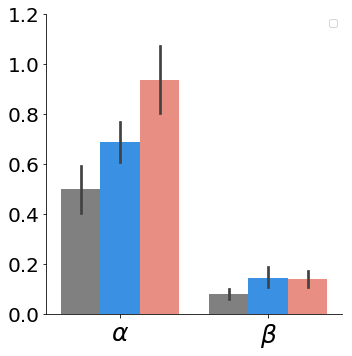

In [10]:
a4_dims = (5,5)
fig, ax = plt.subplots(figsize=a4_dims)      
sns.barplot(x='chain',y='y',hue='dataset',data=df,palette=['Gray','Dodgerblue','Salmon'],ci=68)
sns.despine()
plt.yticks(fontsize=20)
plt.xticks(np.arange(2),[r'$\alpha$',r'$\beta$'],fontsize=25)
plt.xlabel('')
plt.ylabel('')  
plt.tight_layout()
plt.legend('')
plt.ylim([0,1.2])

plt.show()
plt.close()